Let's add NIAK to the path

In [2]:
cd
build_path niak psom

Adding library niak to the search path.

Adding library psom to the search path.



# time window correlation map
Let's start by loading an fMRI dataset

In [4]:
path_data = '/home/pbellec/data/recon/fmri/'; % synced from guillimin database/database/recon/quarantine_niakissue100_2016_03_08/fmri_preprocess
file = [path_data 'fmri_rc_001_session1_run1.mnc.gz'];
[hdr,vol] = niak_read_vol(file);

Let's check the dimensions of our dataset: $53 \times 64 \times 52$ voxels with 205 time points.

In [7]:
size(vol)

ans =

    53    64    52   205



Now let's load a brain parcellation

In [6]:
cd(path_data)
niak_gb_vars
file_parcels = [gb_niak_path_niak 'template' filesep 'basc_cambridge_sc100.mnc.gz'];
[hdr_p,mask] = niak_read_vol(file_parcels);

Let's visualize the parcels:

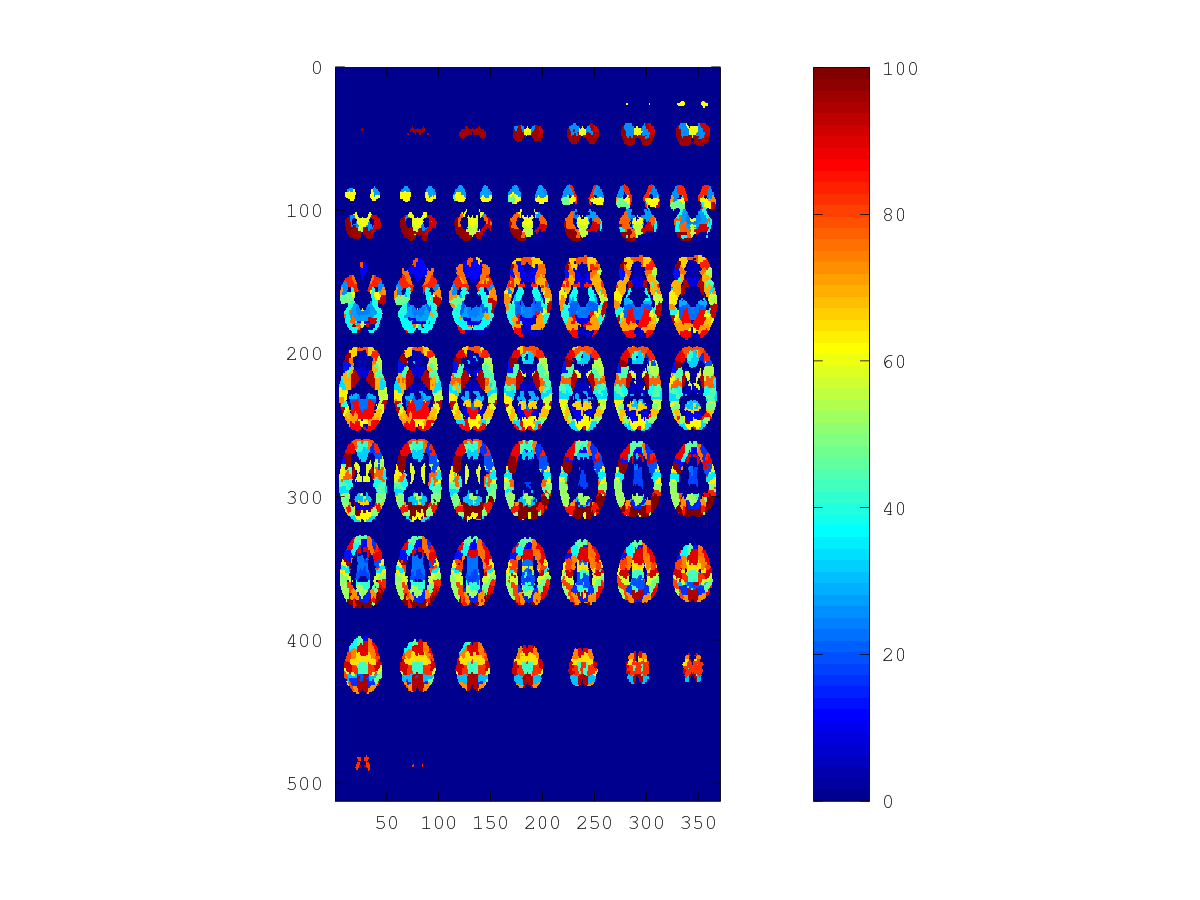

In [8]:
niak_montage(mask)

Time to compute a dynamic connectivity map:

In [25]:
mask_brain = mask>0;
mask_seed = mask == 50;
list_ww = floor(linspace(1,size(vol,4),10)); % the time window
all_map = zeros(sum(mask_brain(:)),length(list_ww)-1);
for ww = 1:(length(list_ww)-1)
    niak_progress(ww,length(list_ww)-1)
    rmap = niak_build_rmap(vol(:,:,:,list_ww(ww):list_ww(ww+1)),mask_seed,mask_brain);
    all_map(:,ww) = rmap(mask_brain);
end


    Percentage done: 20 30 40 55 65 75 85 100


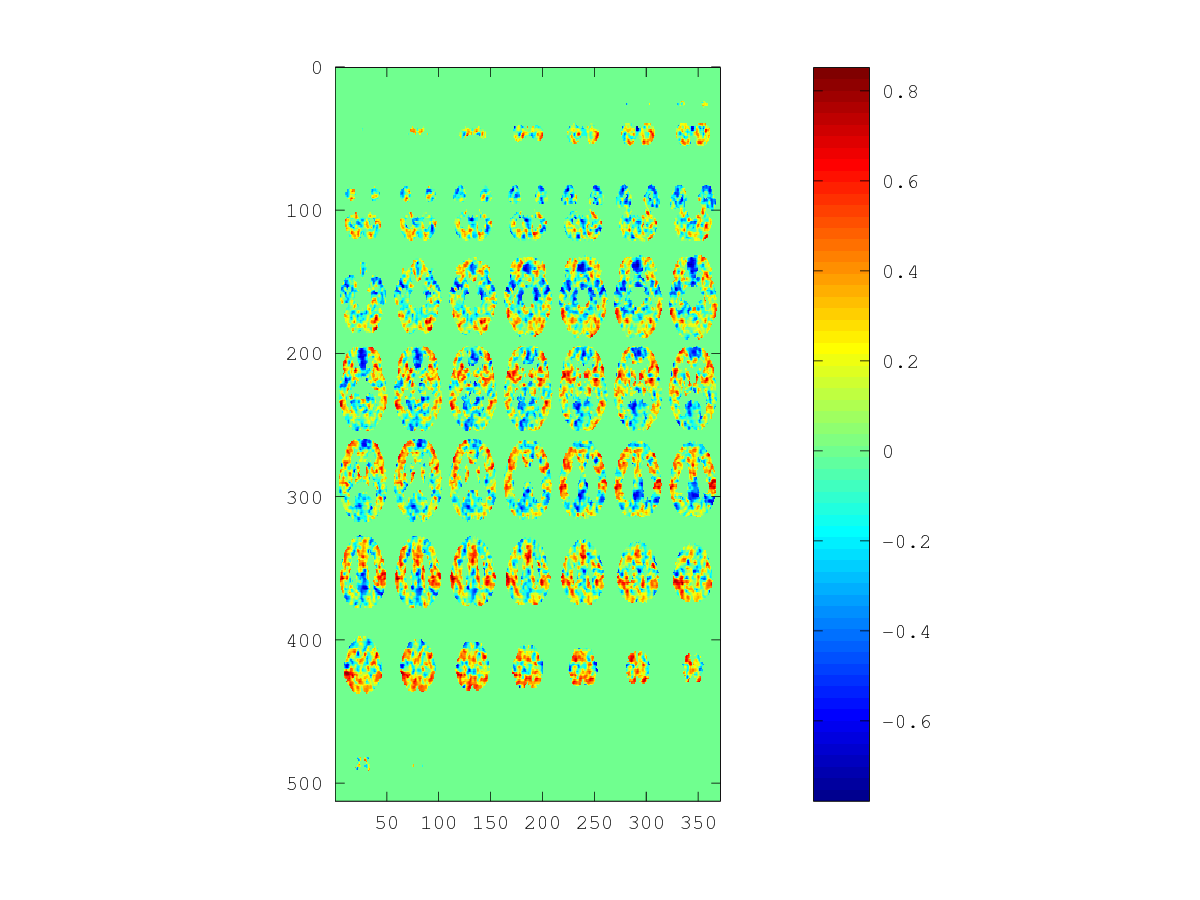

In [29]:
map_voxel = niak_tseries2vol(all_map(:,2)',mask_brain);
niak_montage(map_voxel)

Let's find subtypes (normally we would pool `all_maps` across many subjects and 4D volumes)

     Percentage done : 0 12 25 38 50 62 75 88 100 Done ! 


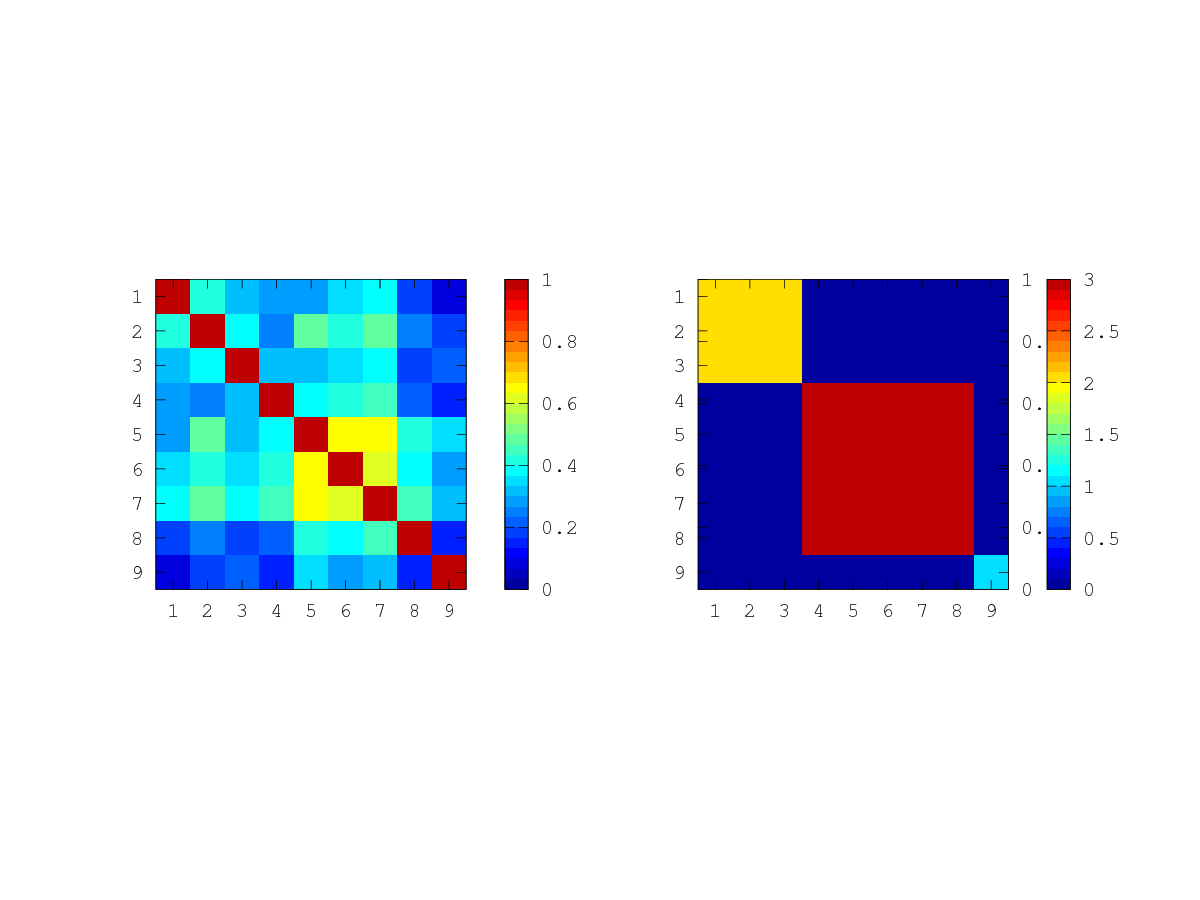

In [32]:
nb_subtype = 3;
R_maps = niak_build_correlation(all_map);
hier = niak_hierarchical_clustering(R_maps);
order = niak_hier2order(hier);
subplot(1,2,1)
niak_visu_matrix(R_maps(order,order));
part = niak_threshold_hierarchy(hier,struct('thresh',nb_subtype));
subplot(1,2,2)
niak_visu_part(part(order));

In [36]:
subtype = zeros(size(all_map),nb_subtype);
for ss = 1:nb_subtype
    subtype(:,ss) = mean(all_map(:,part==ss),2);
end

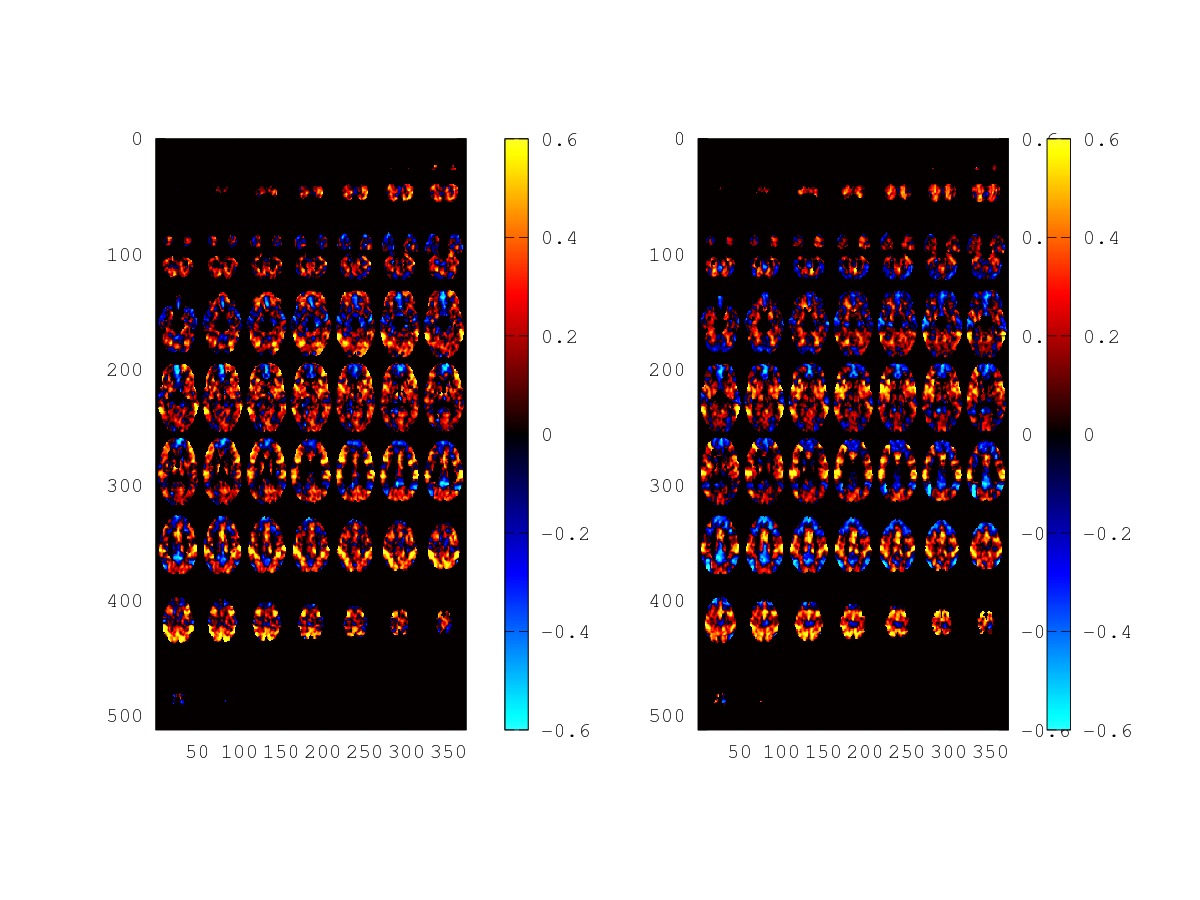

In [45]:
opt_v = struct;
opt_v.vol_limits = [-0.6 0.6];
opt_v.type_color = 'hot_cold';
subplot(1,2,1)
niak_montage(niak_tseries2vol(subtype(:,2)',mask_brain),opt_v)
subplot(1,2,2)
niak_montage(niak_tseries2vol(subtype(:,3)',mask_brain),opt_v)


Let's build weights

In [49]:
weights = zeros(size(all_map,2),nb_subtype);
for ss = 1:nb_subtype
    for ww = 1:size(all_map,2)
        weights(ww,ss) = corr(all_map(:,ww),subtype(:,ss));
    end
end


ans =  1


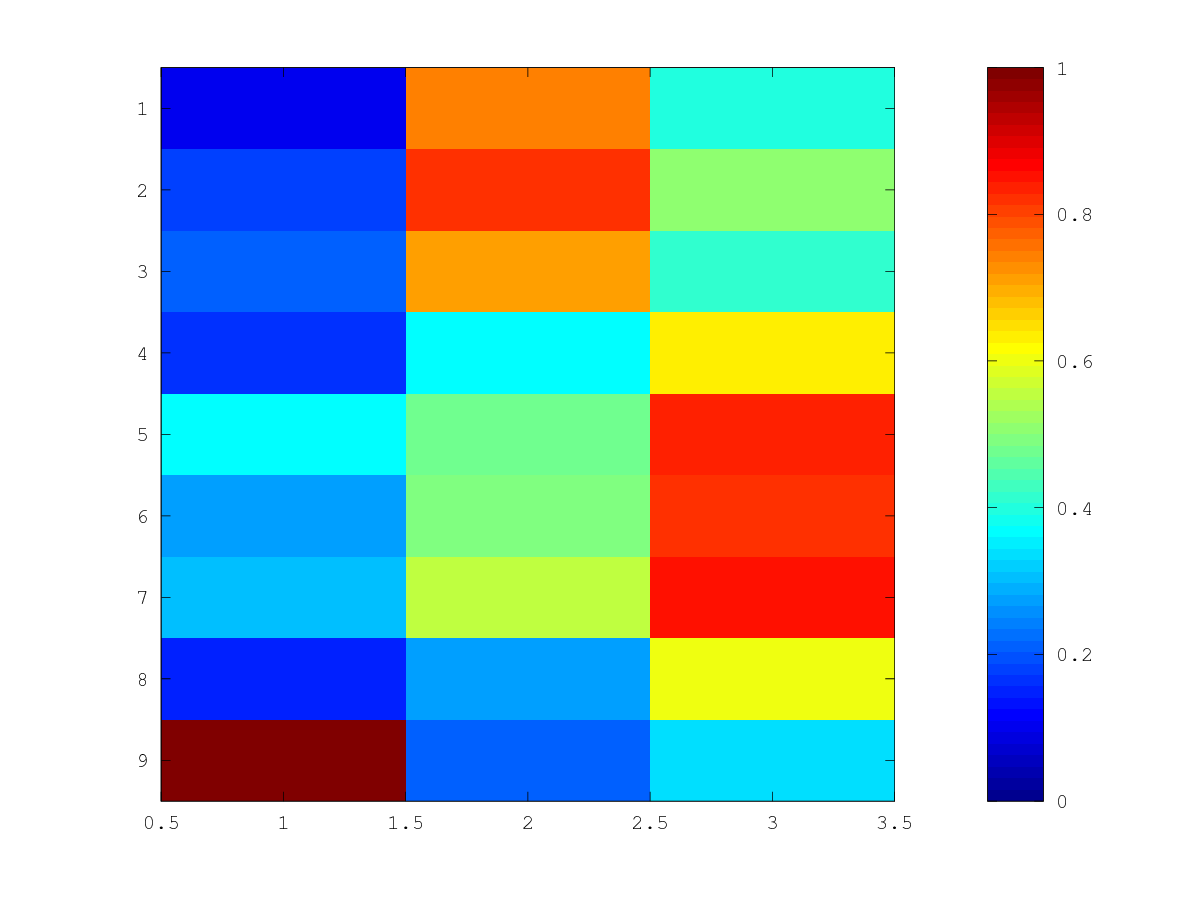

In [51]:
niak_visu_matrix(weights(order,:))

Finally let's run a test

In [55]:
glm.x = [ones(size(weights,1),1) [zeros(4,1) ; ones(5,1)]];
glm.y = weights;
glm.c = [0 1];
opt_glm.test = 'ttest';
res = niak_glm(glm,opt_glm);

In [56]:
res.pce

ans =

   0.572296   0.923733   0.026266

